# Obtaining Beta using Kalmann Filters #

In [255]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Data
import yfinance as yf

# Statistics
import statsmodels.api as sm
from pykalman import KalmanFilter

# Pretty Notation
from IPython.display import display, Math

In [256]:
# Import the Stock Data

ticker = 'MSFT'

stock = pd.read_csv(rf"..\stocks\{ticker}.csv")
stock = stock.set_index('Date')
stock.index = pd.to_datetime(stock.index)
stock = stock['Adjusted_close'].dropna()

stock

Date
1998-01-02     16.390625
1998-01-05     16.296875
1998-01-06     16.390625
1998-01-07     16.195313
1998-01-08     16.312500
                 ...    
2024-10-22    427.510000
2024-10-23    424.600000
2024-10-24    424.730000
2024-10-25    428.150000
2024-10-28    426.590000
Name: Adjusted_close, Length: 6749, dtype: float64

In [257]:
# Import the Additional Data

# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500

sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index, dayfirst=True)

# Get the betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

In [258]:
# Obtaining the Daily RFR

risk_free_daily = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)

# Obtaining Returns
stock_returns = stock.pct_change().dropna()
market_returns = sp500['sp_500'].pct_change().dropna()

# Calculate the excess
excess_stock_returns = (stock_returns - risk_free_daily).dropna()
excess_market_returns = (market_returns - risk_free_daily).dropna()

In [259]:
# Common Index

common_index = excess_stock_returns.index.intersection(excess_market_returns.index)  # Common DATE
excess_stock_returns = excess_stock_returns.reindex(common_index)
excess_market_returns = excess_market_returns.reindex(common_index)

In [260]:
# Make sure excess_stock_returns and excess_market_returns are column vectors (T, 1)
excess_stock_returns = excess_stock_returns.values.reshape(-1, 1)
excess_market_returns = excess_market_returns.values.reshape(-1, 1)

print(excess_stock_returns.shape)
print(excess_market_returns.shape)

(2420, 1)
(2420, 1)


In [261]:
# Calculate the Beta Using Kalman Filter

# Define the Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.array([[1]]),  # (1,1) matrix for single beta
    observation_matrices=excess_market_returns.reshape(-1, 1, 1),  # (T,1,1)
    initial_state_mean=1,  # Initial beta
    initial_state_covariance=1,  # High uncertainty
    transition_covariance=np.array([[0.01]]),  # Process noise
    observation_covariance=np.array([[0.01]])  # Observation noise
)


In [262]:
# Apply Kalman Filter
filtered_state_means, _ = kf.filter(excess_stock_returns)
filtered_state_means = pd.DataFrame(filtered_state_means, index = common_index) 
filtered_state_means.columns = ['Kalman Beta']

filtered_state_means

,Kalman Beta
Date,
2015-02-24,0.998887
2015-02-25,0.999012
2015-02-26,0.998551
2015-02-27,0.999078
2015-03-02,0.995667
...,...
2024-10-22,1.096088
2024-10-23,1.092356
2024-10-24,1.091848


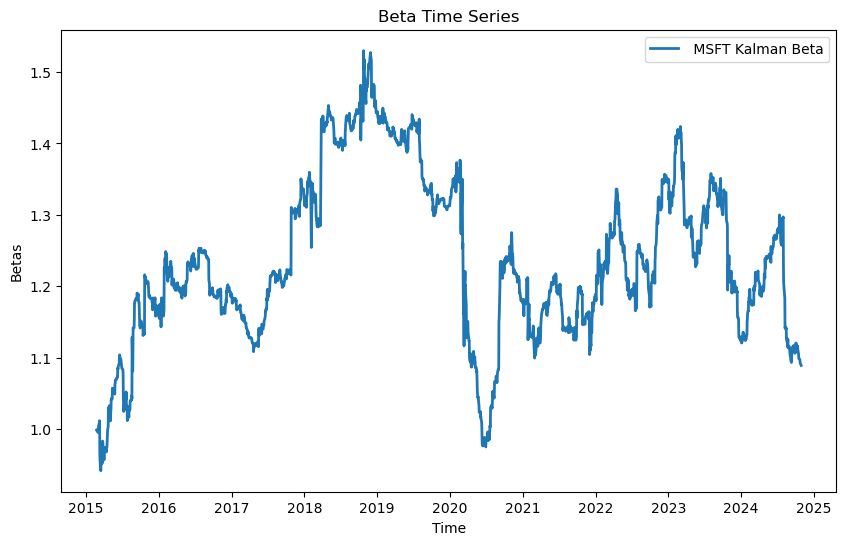

In [263]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(filtered_state_means, label=f" {ticker} Kalman Beta", linewidth=2)

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

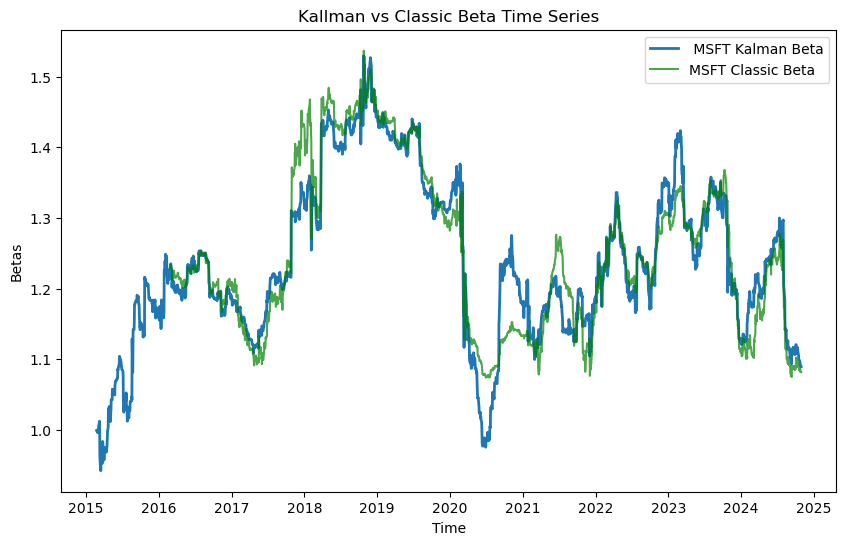

In [264]:
# Create Comparative Plot

plt.figure(figsize=(10, 6))
plt.plot(filtered_state_means, label=f" {ticker} Kalman Beta", linewidth=2)
plt.plot(betas_df[ticker], label=f'{ticker} Classic Beta', color='green', alpha=0.7)

# Config
plt.title('Kallman vs Classic Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

Kalman betas tend to provide a smoother estimation of a stock's sensitivity to market movements. One key advantage of the Kalman filter is that it does not lose observations compared to rolling regression. However, it assumes high uncertainty at the start of the period.

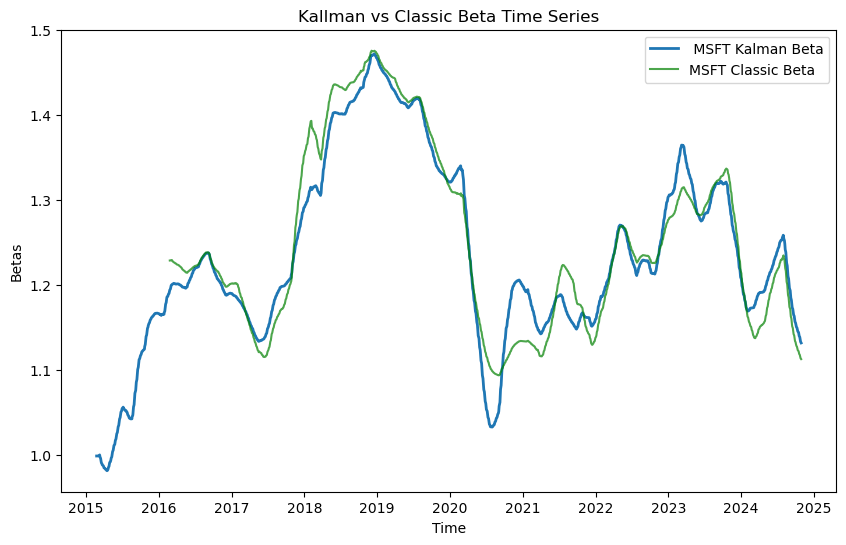

In [266]:
# Create Comparative Plot

plt.figure(figsize=(10, 6))
plt.plot(filtered_state_means.ewm(span=63, adjust = False).mean(), label=f" {ticker} Kalman Beta", linewidth=2)
plt.plot(betas_df[ticker].ewm(span=63, adjust = False).mean(), label=f'{ticker} Classic Beta', color='green', alpha=0.7)

# Config
plt.title('Kallman vs Classic Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

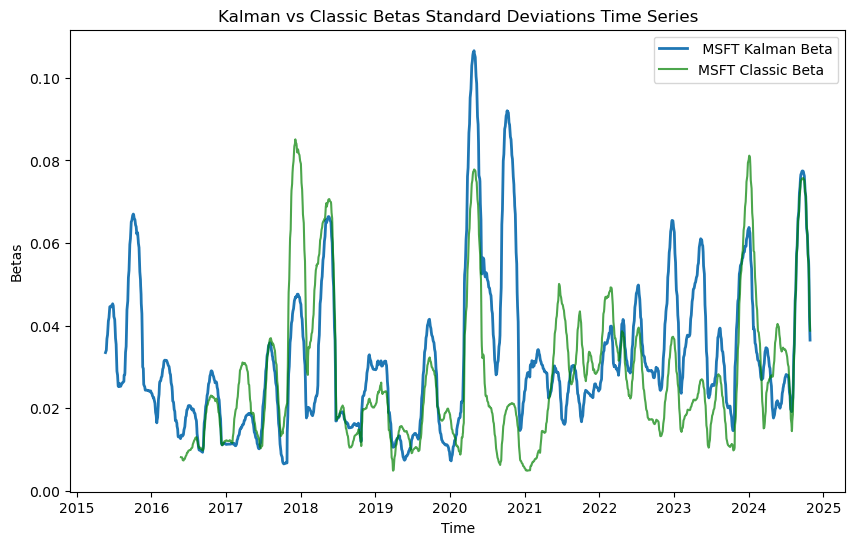

In [267]:
# Create Comparative Plot

plt.figure(figsize=(10, 6))
plt.plot(filtered_state_means.rolling(window=63).std(), label=f" {ticker} Kalman Beta", linewidth=2)
plt.plot(betas_df[ticker].rolling(window=63).std(), label=f'{ticker} Classic Beta', color='green', alpha=0.7)

# Config
plt.title('Kalman vs Classic Betas Standard Deviations Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

Apparently Kalman's Beta captures faster the movements of the COVID-19 pandemic than the classical beta estimation.